In [1]:
__author__ = "Jon Ball"
__version__ = "November 2023"

In [2]:
from lxml import etree
from collections import Counter
import matplotlib.pyplot as plt
import requests
import random
import json
import time
import os

In [3]:
# set random seed
random.seed(42)

In [4]:
with open ("../data/eric/se.json", "r") as infile:
    se = json.load(infile)

(array([ 78., 128., 115.,  98., 111.,  88., 124.,  82., 112.,  99.]),
 array([1968. , 1973.5, 1979. , 1984.5, 1990. , 1995.5, 2001. , 2006.5,
        2012. , 2017.5, 2023. ]),
 <BarContainer object of 10 artists>)

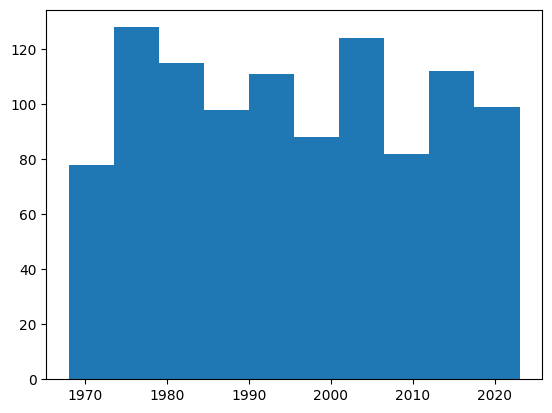

In [5]:
yrs = []
for doc in se["response"]["docs"]:
    yrs.append(doc["publicationdateyear"])
countD = Counter(yrs)
plt.hist(yrs)

In [6]:
print({f"{k}": v for k, v in sorted(countD.items(), key=lambda item: item, reverse=True)})

{'2023': 12, '2022': 16, '2021': 18, '2020': 19, '2019': 18, '2018': 16, '2017': 18, '2016': 23, '2015': 17, '2014': 16, '2013': 18, '2012': 20, '2011': 18, '2010': 16, '2009': 16, '2008': 16, '2007': 16, '2006': 16, '2005': 19, '2004': 17, '2003': 22, '2002': 17, '2001': 33, '2000': 14, '1999': 13, '1998': 16, '1997': 18, '1996': 27, '1995': 16, '1994': 17, '1993': 15, '1992': 19, '1991': 23, '1990': 21, '1989': 18, '1988': 20, '1987': 21, '1986': 20, '1985': 19, '1984': 26, '1983': 18, '1982': 18, '1981': 12, '1980': 21, '1979': 20, '1978': 22, '1977': 20, '1976': 30, '1975': 28, '1974': 28, '1973': 27, '1972': 16, '1971': 25, '1970': 9, '1968': 1}


In [7]:
data_dir = "../../ERIC/data"

In [8]:
%%time
control_ids = []
for dirname, dirpath, _ in os.walk(data_dir):
    if dirname != data_dir:
        for _, _, files in os.walk(dirname):
            for file in files:
                if file.endswith(".xml"):
                    yr = int(file[4:8])
                    if yr in countD:
                        count = countD[yr]
                        with open(os.path.join(dirname, file), "r") as infile:
                            xml = infile.read()
                        namespaces = {"dc": "http://purl.org/dc/elements/1.1/", "eric": "http://eric.ed.gov/"}
                        root = etree.fromstring(xml)
                        ids = [id.text for id in root.xpath("//dc:identifier", namespaces=namespaces) if id.text and id.text.startswith("EJ")]
                        if ids:
                            # pick `count` random ids
                            ids = random.sample(ids, count)
                            control_ids.extend(ids)

CPU times: user 47.8 s, sys: 8.62 s, total: 56.4 s
Wall time: 56.2 s


In [9]:
print(f"Number of control ids: {len(control_ids)}")

Number of control ids: 1022


### Get json records from eric api

In [10]:
url_a = "https://api.ies.ed.gov/eric/?search=id%3A%22"
url_b = "%22&format=json&rows=1"

In [11]:
%%time 
randomD = {}
for id in control_ids:
    url = url_a + id + url_b
    r = requests.get(url)
    if r.status_code == 200:
        rec = json.loads(r.text)
        randomD[id] = rec["response"]["docs"][0]
print(f"Number of json responses: {len(randomD)}")

Number of json responses: 1022
CPU times: user 23.2 s, sys: 1.12 s, total: 24.3 s
Wall time: 10min 46s


In [15]:
randomD = {"response": {"docs": list(randomD.values())}}
with open("../data/eric/random.json", "w") as outfile:
    json.dump(randomD, outfile)